In [14]:
import cv2
import numpy as np
import os
import sys
import tutils
from bokeh.plotting import figure, show,output_file
from bokeh.layouts import gridplot
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#fname='/Users/Jaiyam/Dropbox/New Beads Videos/20181128 SAM 45uM/tracking/20181128_sam_45uM_1.mov'
folder="/Users/Jaiyam/Dropbox/New Beads Videos/20181203 SAM 15uM/tracking/expt3/"
all_beads_file='20181203_sam_15uM_3_data.txt'
stopped_beads_file='20181203_sam_15uM_3_data_stopped.txt'

In [3]:
with open(folder+all_beads_file,'r') as f:
    all_beads=eval(f.read())
    
with open(folder+stopped_beads_file,'r') as f:
    stopped_beads=eval(f.read())

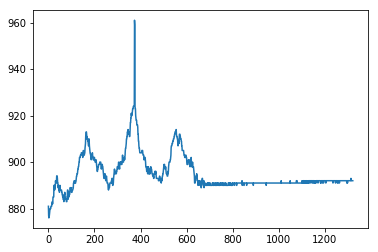

In [11]:
x,y=zip(*stopped_beads[54])

plt.plot(y)
plt.show()

In [19]:
for bnum in [54,36,15,30]:
    x,y=zip(*stopped_beads[bnum])
    x,y=np.array(x),np.array(y)
    for idx,traj in all_beads.iteritems():
        _x,_y=zip(*traj)
        _x,_y=np.array(_x),np.array(_y)
        if x.shape==_x.shape:
            if np.sum(abs(x - _x)+abs(y-_y))==0:
                print(bnum,idx)

(54, 443)
(36, 186)
(15, 44)
(30, 152)


In [15]:
type(all_beads)

dict

In [3]:
source=cv2.VideoCapture(fname)

In [4]:
ret,frame=source.read()

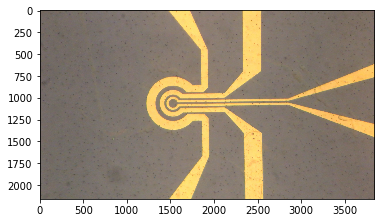

In [5]:
plt.imshow(frame[:,:,::-1])
plt.show()

In [6]:
os.mkdir('miyashita_ncc_demo')

In [7]:
cv2.imwrite('miyashita_ncc_demo/original.jpg',frame)

True

In [8]:
template=cv2.imread('templates/2.8um_1mM_temp.jpg',0)

In [9]:
gray=cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
ncc_result=cv2.matchTemplate(gray,template,cv2.TM_CCOEFF_NORMED)

In [11]:
cv2.imwrite('miyashita_ncc_demo/ncc_output.jpg',ncc_result*255)

True

In [16]:
ncc_filtered=ncc_result*(ncc_result>=0.7)

In [17]:
gray_filtered=gray*(gray>=255*0.7)

In [19]:
cv2.imwrite('miyashita_ncc_demo/ncc_filtered.jpg',ncc_filtered*255)
cv2.imwrite('miyashita_ncc_demo/gray_filtered.jpg',gray_filtered)

True

In [15]:
gray_filtered.shape

(1046875,)

In [20]:
cv2.imwrite('miyashita_ncc_demo/gray_image.jpg',gray)

True

## Draw beads trajectory graph

In [4]:
txtfile='/Users/Jaiyam/Dropbox/New Beads Videos/20181226 Biotin simple/tracking/1uM_1/20181226_biotin_1uM_data_stopped.txt'

In [10]:
tracked_objs=tutils.load_beads(txtfile)

In [11]:
len(tracked_objs)

47

In [8]:
def plot_pos_freq(bnums,htmlname,fs=7.5,coord='x'):
    pixels_in_a_micron=20.0
    figs=[]
    p1=figure()
    p2=figure(x_axis_type="log")#,y_axis_type="log")
    p3=figure(x_axis_type="log")#,y_axis_type="log")
    colors=['red','green','blue','black','orange','firebrick','fuchsia','indigo','magenta']
    for b_num in bnums:
        if coord=='x':
            pos=[c[0]/pixels_in_a_micron for c in tracked_objs[b_num].previous_centers]
        elif coord=='y':
            pos=[c[1]/pixels_in_a_micron for c in tracked_objs[b_num].previous_centers]
            
        #l2dist=lambda tuple1,tuple2: np.sqrt((tuple1[0]-tuple2[0])**2+(tuple1[1]-tuple2[1])**2)/6.0
        pos=[posn-pos[0] for posn in pos]
        p1.line([idx/float(fs) for idx in range(len(pos))],pos,legend='Position (#'+str(b_num)+')',color=colors[bnums.index(b_num)])
        n=len(pos)
        len_out=n//2 + 1
        maxf=fs/2.0 if n%2==0 else fs*(n-1)/(2.0*n)
        frequencies=maxf*np.arange(len_out)/len_out
        fftarr=np.fft.rfft(np.array(pos))
        ys=np.abs(fftarr)
        #print(fftarr)
        phase=np.arctan(np.imag(fftarr)/np.real(fftarr))
        #print(phase)
        #ys[1:]*=2 #
        p2.line(frequencies,np.log10(ys)/np.max(np.log10(ys)),legend='Frequency (#'+str(b_num)+')',color=colors[bnums.index(b_num)])
        p3.line(frequencies,phase,legend='Phase (#'+str(b_num)+')',color=colors[bnums.index(b_num)])
    
    p1.xaxis.axis_label='Time (s)'
    p1.yaxis.axis_label='Position (um)'
    p1.legend.click_policy='hide'
    p1.legend.location='top_left'
    p2.xaxis.axis_label='Frequency (Hz)'
    p2.yaxis.axis_label='Normalized log(Amplitude)'
    p2.legend.click_policy='hide'
    p3.xaxis.axis_label='Frequency (Hz)'
    p3.yaxis.axis_label='Phase'
    p3.legend.click_policy='hide'
    figs.append([p1,p2])
    figs.append([p3])
    output_file(htmlname,title='Analysis of beads position')
    grid=gridplot(figs)
    show(grid)

In [19]:
plot_pos_freq([4,5,6],'./tracked_objs.html',fs=24,coord='x')